<a href="https://colab.research.google.com/github/bhaskoro-muthohar/Mapping-Tempat-Populer-di-Pekanbaru/blob/master/Mapping_Tempat_Populer_di_Pekanbaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#creating_map_time.ipynb

In [0]:
!pip install folium

In [0]:
import pandas as pd
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import TimestampedGeoJson
import json
import matplotlib.pyplot as plt

##Importing places

For now let's import the places dataset and learn about it. Then plot in a folium map circles to see how our places are distributed.

In [4]:
pekanbaru_places = pd.read_csv('places_cleaned.csv')
pekanbaru_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 12 columns):
place_name    94 non-null object
place_id      94 non-null object
lat           94 non-null float64
lng           94 non-null float64
type          94 non-null object
monday        94 non-null object
tuesday       94 non-null object
wednesday     94 non-null object
thursday      94 non-null object
friday        94 non-null object
saturday      94 non-null object
sunday        94 non-null object
dtypes: float64(2), object(10)
memory usage: 8.9+ KB


As we can see, we've got 94 places in Pekanbaru. They have identification and localization data and also (monday to sunday) columns that represents the mean place occupancy on that weekday. These values for occupancy are lists of 23 positions (one for each hour in the day). Here is a sample:

In [5]:
pekanbaru_places.tuesday[0]

'[0, 0, 0, 0, 7, 16, 28, 39, 47, 52, 56, 59, 60, 58, 53, 44, 36, 29, 24, 19, 15, 10, 5, 0]'

Now let's create a map see how distributed are our places:

In [0]:
pekanbaru = folium.Map(location=[0.507068,101.447777], zoom_start=13)

for index, place in pekanbaru_places.iterrows():
    folium.Marker(location=[place.lat, place.lng], popup=place.place_name).add_to(pekanbaru)
pekanbaru

##Creating the map

In [6]:
places_types = list(pekanbaru_places.type.unique())
places_types

['airport',
 'bank',
 'bar',
 'beauty_salon',
 'book_store',
 'cafe',
 'mosque',
 'doctor',
 'dentist',
 'gym',
 'hair_care',
 'hospital',
 'pharmacy',
 'pet_store',
 'night_club',
 'movie_theater',
 'shopping_mall',
 'supermarket',
 'store']

In [0]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
          '#bcf60c', '#cb93d2', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', 
          '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

This next function definition generates and returns a new map filtered based on weekday, hour and a subset of places types as list.

In [0]:
def generate_map(weekday, hour, types=places_types):
    pekanbaru = folium.Map(location=[0.507068,101.447777], zoom_start=13)
    ptypes_groups = {}

    for ptype in types:
        ptypes_groups[ptype] = FeatureGroup(name=ptype)

    for index, place in pekanbaru_places.iterrows():
        moments = json.loads(place[weekday])
        if (place.type in types):
            folium.Circle(location=[place.lat, place.lng], popup=place.place_name + ' ' + place.type, stroke=False, fill=True,
                          radius=int(moments[hour]*3), fill_color=colors[places_types.index(place.type)],
                          fill_opacity=0.6).add_to(ptypes_groups[place.type])

    for ptype, group in ptypes_groups.items():
        group.add_to(pekanbaru)
    LayerControl().add_to(pekanbaru)
    return pekanbaru

In [0]:
generate_map('monday', 10)

Here is our final result! As you can see, each place type has a different color, and can be switched on/off by the top right menu. The circle radius indicates the value of current moment in that place, this stands for wheather the place is very or few populated in that hour.

##Ploting in lines

But... we are not pleased enought with these maps. Wondering if in fact that "moment" values does have a pragmatic meaning, I got the idea of create some plots and see what they say, based on places types.

In order to that we'll need this following function that takes a place type and a weekday and returns to us a list of size 24 (hours in a day). In each position of the list we have the sum of "moments" for each place for the passed place type.


In [0]:
def sum_moments(ptype, weekday):
    places = pekanbaru_places[pekanbaru_places.type==ptype]
    moments = [json.loads(moments) for moments in places[weekday]]
    hih = {}
    for hour in range(0,24):
        hih[hour] = 0
    for moment_idx in range(0, len(moments)):
        for hour in range(0,24):
            hih[hour] = hih[hour] + moments[moment_idx][hour]
    return hih

Then we plot the graph where each line is a weekday. The x-axis is the hour and the y-axis is the moment value.

In [0]:
def plot_weekly_moments(place_type):
    monday = sum_moments(place_type, 'monday')
    tuesday = sum_moments(place_type, 'tuesday')
    wednesday = sum_moments(place_type, 'wednesday')
    thursday = sum_moments(place_type, 'thursday')
    friday = sum_moments(place_type, 'friday')
    saturday = sum_moments(place_type, 'saturday')
    sunday = sum_moments(place_type, 'sunday')
    
    fig, ax = plt.subplots()
    ax.plot(list(monday.keys()), list(monday.values()), label="monday")
    ax.plot(list(tuesday.keys()), list(tuesday.values()), label="tuesday")
    ax.plot(list(wednesday.keys()), list(wednesday.values()), label="wednesday")
    ax.plot(list(thursday.keys()), list(thursday.values()), label="thursday")
    ax.plot(list(friday.keys()), list(friday.values()), label="friday")
    ax.plot(list(saturday.keys()), list(saturday.values()), label="saturday")
    ax.plot(list(sunday.keys()), list(sunday.values()), label="sunday")
    ax.set_title(place_type)
    ax.legend()

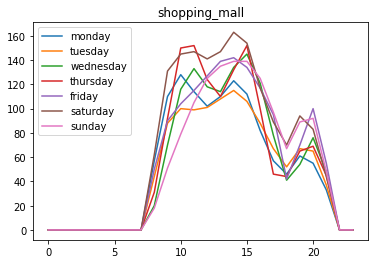

In [9]:
plot_weekly_moments('shopping_mall')

##Creating a Timestamped Map

These next steps generates a new kind of map using folium, here I'm trying a interesting feature called [TimestampedGeoJson](https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimestampedGeoJson).


In [0]:
pekanbaru_map = folium.Map(location=[0.507068,101.447777], zoom_start=13)

In [0]:
pekanbaru_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 12 columns):
place_name    94 non-null object
place_id      94 non-null object
lat           94 non-null float64
lng           94 non-null float64
type          94 non-null object
monday        94 non-null object
tuesday       94 non-null object
wednesday     94 non-null object
thursday      94 non-null object
friday        94 non-null object
saturday      94 non-null object
sunday        94 non-null object
dtypes: float64(2), object(10)
memory usage: 8.9+ KB


In [0]:
pekanbaru_places2 = pd.melt(pekanbaru_places, id_vars=["place_name", "place_id", "lat", "lng", "type"], var_name="weekday", value_name="moments")
pekanbaru_places2.moments = [json.loads(moment) for moment in pekanbaru_places2.moments]

pekanbaru_places2['0'] = [moment[0] for moment in pekanbaru_places2.moments]
pekanbaru_places2

for hour in range(0, 24):
    pekanbaru_places2[str(hour)] = [moment[hour] for moment in pekanbaru_places2.moments]

pekanbaru_places3 = pd.melt(pekanbaru_places2, id_vars=["place_name", "place_id", "lat", "lng", "type", "weekday","moments"], var_name="hour", value_name="moment_value")

del pekanbaru_places3['moments']

pekanbaru_places3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 8 columns):
place_name      15792 non-null object
place_id        15792 non-null object
lat             15792 non-null float64
lng             15792 non-null float64
type            15792 non-null object
weekday         15792 non-null object
hour            15792 non-null object
moment_value    15792 non-null int64
dtypes: float64(2), int64(1), object(5)
memory usage: 987.1+ KB


In [0]:
def gen_date(row):
    print(row.weekday)

times = []
for index, row in pekanbaru_places3.iterrows():
    if row.weekday == 'monday': time = '05/06/2019 '
    if row.weekday == 'tuesday': time = '05/07/2019 '
    if row.weekday == 'wednesday': time = '05/08/2019 '
    if row.weekday == 'thursday': time = '05/09/2019 '
    if row.weekday == 'friday': time = '05/10/2019 '
    if row.weekday == 'saturday': time = '05/11/2019 '
    if row.weekday == 'sunday': time = '05/12/2019 '
    
    time += str(row.hour) + ':00'
    
    times.append(time)
    
pekanbaru_places3['time'] = times
pekanbaru_places3['time'] = pd.to_datetime(pekanbaru_places3['time'])
pekanbaru_places3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 9 columns):
place_name      15792 non-null object
place_id        15792 non-null object
lat             15792 non-null float64
lng             15792 non-null float64
type            15792 non-null object
weekday         15792 non-null object
hour            15792 non-null object
moment_value    15792 non-null int64
time            15792 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 1.1+ MB


In [0]:
pekanbaru_places3.to_csv('pekanbaru_places3.csv')

At this point you can export the "natal_places3" dataset to a .csv file and drop it in the [kepler.gl](https://kepler.gl/)

In [0]:
def create_geojson_features(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row.lng, row.lat]
            },
            'properties': {
                'time': row['time'].date().__str__() + ' ' + row['time'].time().__str__(),
                'style': {'color': 'red'},
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.6,
                    'stroke': True,
                    'radius': row.moment_value/10
                }
            }
        }
        features.append(feature)
    return features

pekanbaru_features = create_geojson_features(pekanbaru_places3)

In [0]:
pekanbaru_features[15000]

{'geometry': {'coordinates': [101.44771779999999, 0.5286059000000001],
  'type': 'Point'},
 'properties': {'icon': 'circle',
  'iconstyle': {'fillColor': 'red',
   'fillOpacity': 0.6,
   'radius': 0.0,
   'stroke': True},
  'style': {'color': 'red'},
  'time': '2019-05-11 22:00:00'},
 'type': 'Feature'}

In [0]:
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': pekanbaru_features},
    period='PT1H',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='DD HH',
    time_slider_drag_update=True
).add_to(pekanbaru_map)
pekanbaru_map.save('pekanbaru_map.html')

~~~~~~~~~~~~~~~~~~~~~~~

In [0]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import json
from math import ceil

WEEK_DAY = 'monday'

# morning (6, 7, 8, 9, 10, 11)
# afternoon (12, 13, 14, 15, 16, 17)
# evening (18, 19, 20, 21)
# night (22, 23, 0, 1, 2, 3, 4, 5)
PERIOD = 'night'

def place_to_hints(place):
    moments = json.loads(place[WEEK_DAY])
    hints = 0
    if PERIOD == 'morning':
        hints = sum(moments[6:12])
    elif PERIOD == 'afternoon':
        hints = sum(moments[12:18])
    elif PERIOD == 'evening':
        hints = sum(moments[18:22])
    else:
        hints = moments[23] + sum(moments[0:6])
    return ceil(hints/40)

def place_hints_per_hour(place, hour):
    moments = json.loads(place[WEEK_DAY])
    hints = moments[hour]
    return ceil(hints/40)

pekanbaru = folium.Map(location=[101.44771779999999,0.5286059000000001], zoom_start=13)

places = pd.read_csv('places_cleaned.csv')

heat_dots = []

for index, row in places.iterrows():
    place_dots = place_hints_per_hour(row, 7) * [[row.lat, row.lng]]
    heat_dots += place_dots
    folium.CircleMarker([row.lat, row.lng], popup=row.place_name, radius=2).add_to(pekanbaru)

HeatMap(heat_dots).add_to(pekanbaru)

pekanbaru.save('pekanbaru.html')
